<a href="https://colab.research.google.com/github/AresDan/ProjectX/blob/main/Final_ProjectX_Interview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical task

## Libraries

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.5 MB/s eta 0:00:00


In [ ]:
import nltk
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
from nltk.corpus import stopwords
import sys

from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Danila-
[nltk_data]     ADM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Danila-
[nltk_data]     ADM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Danila-
[nltk_data]     ADM\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Danila-
[nltk_data]     ADM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Predefined variables

In [ ]:
COMMENT_TEXT = 'comment_text'
TARGET_CLASSES = 'target_classes'
SPLIT_SIZE = 0.1
MAX_LENGTH = 100
BATCH_SIZE = 32
EPOCH = 5
checkpoint_path = './checkpoint/current_checkpoint.pt'

lr = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


## Loading the dataset

Mount my Gdrive for the dataset and to save/load models

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Change the folder where the dataset is located
%cd ./drive/'My Drive'/ProjectX/

dataset = pd.read_excel('./toxic_comment_dataset.xlsx')

In [ ]:
dataset = pd.read_excel('./toxic_comment_dataset.xlsx')

## Dataset preprocessing

There is only one column ('comment_text') that contains text, which is used for classification.

In [ ]:
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
import copy
tmp = copy.deepcopy(dataset)

Remove punctuation and use some other preprocessing techniques. The regex with a sepcified pattern (taken from [NLTK Book](https://www.nltk.org/book/ch03.html#nltk-s-regular-expression-tokenizer)) is used to be able to remove punctuation and not a part of a word.

I have tried also removing stop words and lemmatization, however, it worsen results.

In [ ]:
pattern = r'''(?x)     # set flag to allow verbose regexps
    (?:[A-Z]\.)+       # abbreviations, e.g. U.S.A.
    |(?:[u.s.]\.)+       # abbreviations, e.g. u.s.
    | \w+(?:-\w+)*       # words with optional internal hyphens
    | \$?\d+(?:\.\d+)?%? # currency and percentages, e.g. $12.40, 82%
    | \.\.\.             # ellipsis
    | \!
    | \?
    | [][.,;"'?():-_`]   # these are separate tokens; includes ], [
    '''
cachedStopWords = stopwords.words("english")

def process_sentence(sentence):
    # return none if it is not a string. Later we will remove all nones
    if not isinstance(sentence, str):
        return None

    # lowercase
    sentence = sentence.lower()
    # strip
    sentence = sentence.strip()
    # remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    
    # return none if the string is empty. Later we will remove all nones
    if len(sentence) == 0:
        return None

    # iterate over each word and remove punctuation
    # remove stop words
    text_words = nltk.regexp_tokenize(sentence, pattern)
    text_words_processed = []
    for word in text_words:
        # if it is not a punctuation
        if not (word in string.punctuation): #or word in cachedStopWords
            text_words_processed.append(word)
            
    # lemmitazation
    #lemmatizer = nltk.stem.WordNetLemmatizer()
    #text_words_processed = [lemmatizer.lemmatize(word) for word in text_words_processed]

    return ' '.join(text_words_processed)

# apply function
tmp[COMMENT_TEXT] = tmp[COMMENT_TEXT].apply(process_sentence)

In [ ]:
# we have 122 nan values. Drop them.
print('Nan values: ', tmp['comment_text'].isnull().sum().sum(), '/', tmp.shape[0])
tmp = tmp.dropna()
# drop id column
tmp = tmp.drop('id', axis=1)

tmp.head()

Nan values:  179 / 159571


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why the edits made under my userna...,0,0,0,0,0,0
1,d aww he matches this background colour i m se...,0,0,0,0,0,0
2,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,more i can t make any real suggestions on impr...,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


### Dataset visualization

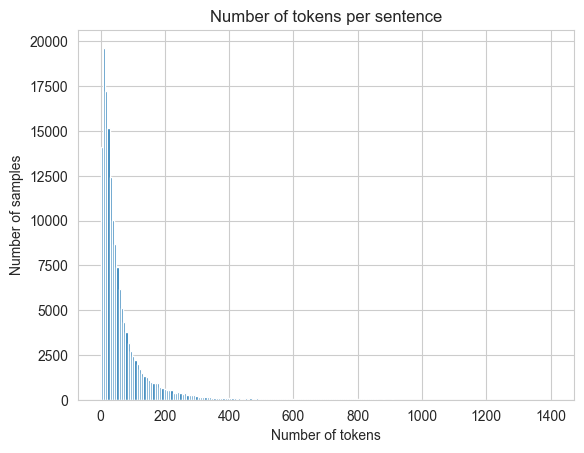


Average number of tokens per sentence: 68.19


In [ ]:
text_length = [len(sample.split()) for sample in tmp[COMMENT_TEXT]]

# plot this information
plt.hist(text_length, bins = 200)
plt.xlabel('Number of tokens')
plt.ylabel('Number of samples')
plt.title('Number of tokens per sentence')
plt.show()

print('\nAverage number of tokens per sentence: {:.2f}'.format(pd.DataFrame(text_length).mean().item()))

Show information about categories that we have

<AxesSubplot:title={'center':'Total number of samples per category'}, xlabel='Category'>

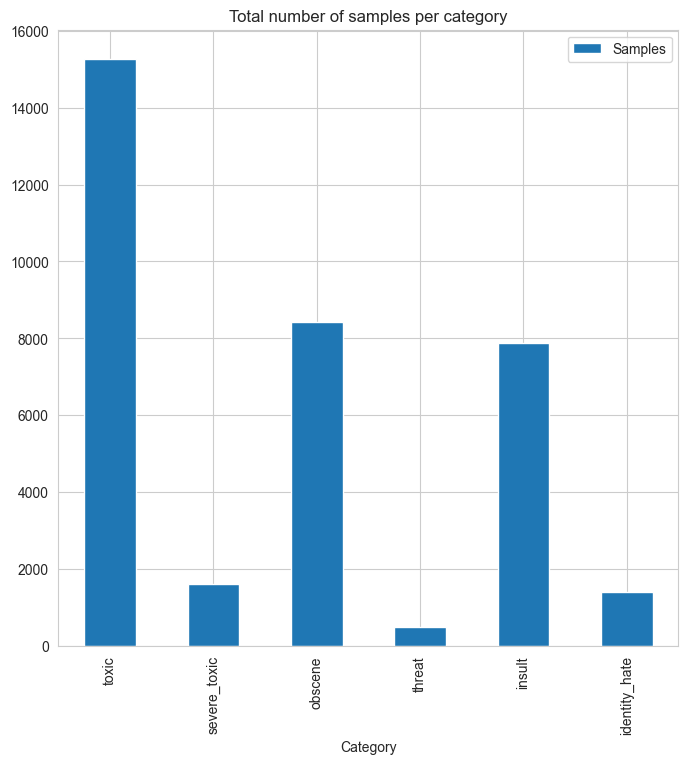

In [ ]:
# category information
y_data = tmp.drop([COMMENT_TEXT], axis=1)
label_count = [ [category, len(np.where(y_data[category] == 1)[0])] for category in list(y_data.columns.values) ]
label_df = pd.DataFrame(label_count, columns=['Category', 'Samples'])   

# plot this information using df.plot() function
label_df.plot(x='Category', y='Samples', title='Total number of samples per category', 
              kind='bar', figsize=(8,8))

## Prepare the dataset for training

Extract categories that we are using

In [ ]:
# add a new column which will be our label
tmp.insert(1, TARGET_CLASSES, [list(sample) for _, sample in y_data.iterrows()] )

label_list = label_df['Category']
labels = dict(zip(label_list, range(0, len(label_list))))
labels

{'toxic': 0,
 'severe_toxic': 1,
 'obscene': 2,
 'threat': 3,
 'insult': 4,
 'identity_hate': 5}

In [ ]:
class DatasetClass(Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.comment = df[COMMENT_TEXT].reset_index(drop=True)
        self.targets = df[TARGET_CLASSES].reset_index(drop=True)
        self.max_len = max_len

    def __len__(self):
        return len(self.comment)

    def __getitem__(self, index):
        comment = str(self.comment[index])
        comment = ' '.join(comment.split())

        inputs = self.tokenizer.encode_plus(
            comment,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

Just shuffling is not a good idea, as samples of a specific category might end up all (or majority) in validation and test dataset and not training or the opposite, when there is not samples in validation or test dataset and all in training. Therefore, the model won't be able to learn anything. Because of this, categories that contains less samples will be fed .

In [ ]:
tmp[tmp['threat'] == 1]

,comment_text,target_classes,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,hi i am back again last warning stop undoing m...,"[1, 0, 0, 1, 0, 0]",1,0,0,1,0,0
176,i think that your a fagget get a oife and burn...,"[1, 0, 1, 1, 1, 1]",1,0,1,1,1,1
600,i m also a sock puppet of this account .. supr...,"[1, 0, 0, 1, 0, 0]",1,0,0,1,0,0
802,fuck you smith please have me notified when yo...,"[1, 0, 1, 1, 1, 0]",1,0,1,1,1,0
1017,wouldn t be the first time bitch fuck you i ll...,"[1, 1, 1, 1, 1, 1]",1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
157718,bitch you are a fucking hore you suck dick you...,"[1, 0, 1, 1, 1, 1]",1,0,1,1,1,1
158717,stupid head your dumb and you are stupid die d...,"[1, 0, 1, 1, 1, 0]",1,0,1,1,1,0
158856,hey hey faggot are you dead yet or are you wat...,"[1, 1, 1, 1, 1, 0]",1,1,1,1,1,0
159029,death to musulmans,"[1, 0, 0, 1, 0, 1]",1,0,0,1,0,1


In [ ]:
def get_datasets(df):
    '''
        Receives a dataset and returns train/val/test dataset with the same 
        balance proportion in each of them.
    '''
    others = df.copy()
    # get rare categories 
    # deleting same entries from the original dataset
    severe_cat = others[others['severe_toxic'] == 1].copy()
    others.drop(others.loc[others['severe_toxic'] == 1].index, inplace=True)

    threat_cat = others[others['threat'] == 1].copy()
    others.drop(others.loc[others['threat'] == 1].index, inplace=True)

    identity_cat = others[others['identity_hate'] == 1].copy()
    others.drop(others.loc[others['identity_hate'] == 1].index, inplace=True)

    # create train/val/test sets
    # we assume that val/test split size is the same
    split_main = int(len(others) * SPLIT_SIZE * 2)
    split_sever = int(len(severe_cat) * SPLIT_SIZE * 2)
    split_threat = int(len(threat_cat) * SPLIT_SIZE * 2)
    split_id = int(len(identity_cat) * SPLIT_SIZE * 2)
    train_set = pd.concat([ others[split_main:], severe_cat[split_sever:], 
                           threat_cat[split_threat:], identity_cat[split_id:] ])

    # val/test sets
    test_split_main = int(len(others) * SPLIT_SIZE)
    test_split_sever = int(len(severe_cat) * SPLIT_SIZE)
    test_split_threat = int(len(threat_cat) * SPLIT_SIZE)
    test_split_id = int(len(identity_cat) * SPLIT_SIZE)
    val_set = pd.concat([ others[test_split_main:split_main], severe_cat[test_split_sever:split_sever], 
                         threat_cat[test_split_threat:split_threat], identity_cat[test_split_threat:split_id] ])
    test_set = pd.concat([ others[:test_split_main], severe_cat[:test_split_sever], 
                          threat_cat[:test_split_threat], identity_cat[:test_split_threat] ])
    
    # shuffle again
    train_set = shuffle(train_set)
    val_set = shuffle(val_set)
    test_set = shuffle(test_set)

    return train_set, val_set, test_set

model_dataset = tmp[[COMMENT_TEXT, TARGET_CLASSES]].copy()
train_set, val_set, test_set = get_datasets(tmp)

train_dataset = DatasetClass(train_set, tokenizer, MAX_LENGTH)
val_dataset = DatasetClass(val_set, tokenizer, MAX_LENGTH)
test_dataset = DatasetClass(test_set, tokenizer, MAX_LENGTH)

We can plot now the distribution of samples among categories, and we can see, that the distribution is the same.

<AxesSubplot:title={'center':'Total number of samples per category'}, xlabel='Category'>

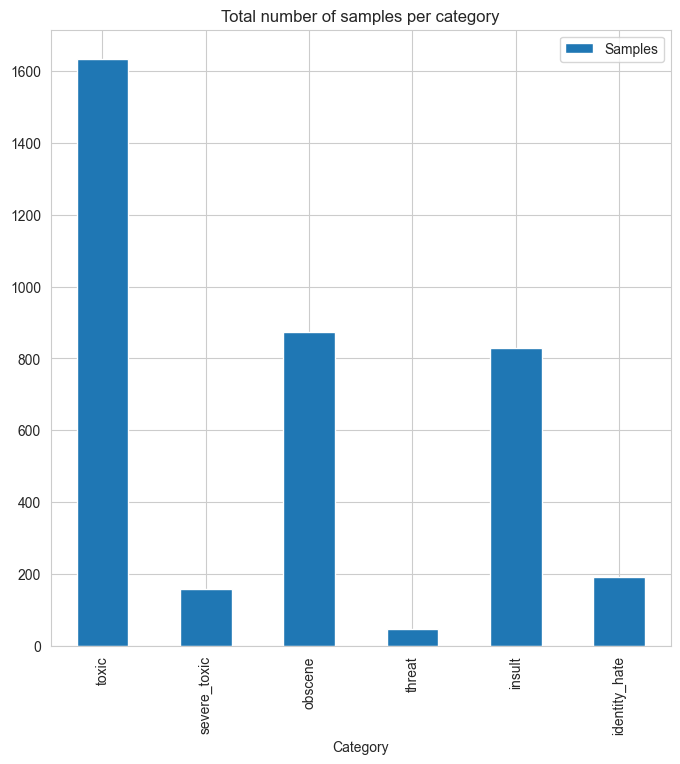

In [ ]:
# category information
y_data = val_set.drop([COMMENT_TEXT, TARGET_CLASSES], axis=1)
label_count = [ [category, len(np.where(y_data[category] == 1)[0])] for category in list(y_data.columns.values) ]
label_df = pd.DataFrame(label_count, columns=['Category', 'Samples'])   

# plot this information using df.plot() function
label_df.plot(x='Category', y='Samples', title='Total number of samples per category', 
              kind='bar', figsize=(8,8))

In [ ]:
train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(train_dataset, **train_params)
validation_loader = DataLoader(val_dataset, **test_params)
test_loader = DataLoader(test_dataset, **test_params)

### BERT model define

In [ ]:
class TransformerBERT(torch.nn.Module):
    '''
        My BERT Transformer model consists of BERT encoder and a dropout
        with linear layer, nothing extra complicated.
    '''
    def __init__(self):
        global labels
        super(TransformerBERT, self).__init__()

        self.encoder = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.3),
            torch.nn.Linear(768, len(labels))
            )
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.encoder(ids, attention_mask=mask, token_type_ids=token_type_ids, 
                                  return_dict=False)
        prob_out = self.classifier(output_1)

        return prob_out

model = TransformerBERT()
model.to(device);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Define loss and optimizer

In [ ]:
loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [ ]:
def load_model(checkpoint_path, model, optimizer, device):
    '''
        Loading the model from the specified checkpoint_path.
        Model variable is used as a target model, when the optimizer is used
        as a target optimizer
    '''
    # load checkpoint
    checkpoint = torch.load(checkpoint_path)
    # initialize state_dict
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer, checkpoint['epoch']

## Training

In [ ]:
def train_model(start_epochs,  n_epochs, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path): 
    for epoch in range(start_epochs, n_epochs+1):
        train_loss = 0
        valid_loss = 0

        ##### Training #####
        model.train()
        print('Training started for epoch ', epoch)

        for batch_idx, data in enumerate(training_loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            optimizer.zero_grad()
            predictions = model(ids, mask, token_type_ids)

            loss = loss_func(predictions, targets)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))

            if batch_idx % 100 == 0:
                print('Batch: ', batch_idx, '/', len(training_loader))

        ##### Validation #####
        print('Training finished for epoch ', epoch)
        print('Validation started for epoch ', epoch) 
        model.eval()

        # no_grad is used as we use a validation set
        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader, 0):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)

                outputs = model(ids, mask, token_type_ids)
                loss = loss_func(outputs, targets)

                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))

                if batch_idx % 100 == 0:
                    print('Batch: ', batch_idx, '/', len(validation_loader))

            print('Validation finished for epoch ', epoch) 
            # calculate average losses
            train_loss = train_loss/len(training_loader)
            valid_loss = valid_loss/len(validation_loader)
            print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

            # create checkpoint
            checkpoint = {
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch + 1
            }

            # save checkpoint
            torch.save(checkpoint, checkpoint_path)

    print('Finished training')
    
    return model

In [ ]:
trained_model = train_model(1, 2, training_loader, validation_loader, model, optimizer, checkpoint_path)

## Testing and confusion matrix

In [ ]:
def test_model(test_loader, model):
    y_true = []
    y_pred = []
    
    model.eval()

    # no_grad is used as we use a validation set
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)

            y_true.extend(targets.cpu().detach().numpy().tolist())
            y_pred.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            if batch_idx % 100 == 0:
                print('Batch: ', batch_idx, '/', len(test_loader))

    return y_true, y_pred

In [ ]:
loaded_model, _, _ = load_model(checkpoint_path, model, optimizer, device)

In [ ]:
y_true, y_pred = test_model(test_loader, loaded_model)

Batch:  0 / 496
Batch:  100 / 496
Batch:  200 / 496
Batch:  300 / 496
Batch:  400 / 496


We define the category to belong to a specific class if the output is more than 0.5

In [ ]:
test_preds = (np.array(y_pred) > 0.5).astype(int)
cm = mcm(y_true, test_preds)

In [ ]:
def plot_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the category - " + class_label)

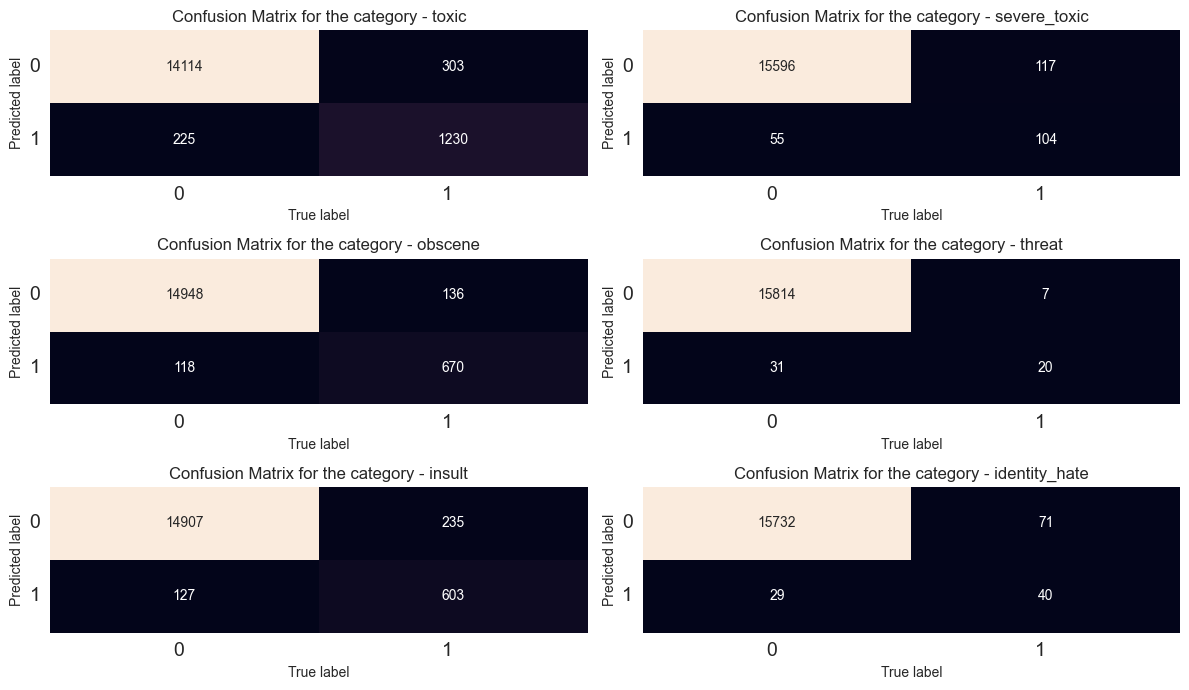

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(3, 2, figsize=(12, 7))

for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels.keys()):
    plot_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])
    
fig.tight_layout()
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(y_true, test_preds)
f1_score_micro = metrics.f1_score(y_true, test_preds, average='micro')
f1_score_macro = metrics.f1_score(y_true, test_preds, average='macro')

print('Accuracy Score: ', accuracy)
print('F1 Score (Micro): ', f1_score_micro)
print('F1 Score (Macro): ', f1_score_macro)

Accuracy Score:  0.9272303427419355
F1 Score (Micro):  0.7857984678845021
F1 Score (Macro):  0.6562852751241013


In [ ]:
|